In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

condo_data_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/condo_data_engineered.csv'
landed_data_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/landed_data_engineered.csv'

print(f"Condo data file exists: {os.path.exists(condo_data_path)}")
print(f"Landed data file exists: {os.path.exists(landed_data_path)}")

Condo data file exists: True
Landed data file exists: True


In [ ]:
import pandas as pd

try:
    condo_data = pd.read_csv(condo_data_path)
    landed_data = pd.read_csv(landed_data_path)

    print(f"Condo data shape: {condo_data.shape}")
    print(f"Landed data shape: {landed_data.shape}")

    print("\nCondo data sample:")
    print(condo_data.head())

    print("\nLanded data sample:")
    print(landed_data.head())

except Exception as e:
    print(f"Error loading data: {e}")

Error loading data: [Errno 2] No such file or directory: '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/condo_data_engineered.csv'


In [ ]:
def check_data_quality(df, dataset_name):
    print(f"\n----- Data Quality Check for {dataset_name} -----")

    missing_values = df.isnull().sum()
    print(f"Columns with missing values:")
    print(missing_values[missing_values > 0])

    print("\nData types:")
    print(df.dtypes)

    duplicate_count = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicate_count}")

    print("\nBasic statistics for numerical columns:")
    print(df.describe().T)

check_data_quality(condo_data, "Condo Data")
check_data_quality(landed_data, "Landed Data")


----- Data Quality Check for Condo Data -----
Columns with missing values:
x_coord    13617
y_coord    13617
dtype: int64

Data types:
street                   object
project_name             object
x_coord                 float64
y_coord                 float64
market_segment           object
area_sqm                float64
floor_range              object
units                     int64
contract_date_raw         int64
type_of_sale              int64
price                     int64
property_type            object
district                  int64
type_of_area             object
tenure                   object
transaction_date         object
year                      int64
quarter                   int64
year_quarter             object
price_psm               float64
geocoding_address        object
latitude                float64
longitude               float64
geocoded_postal_code     object
geocoded_building        object
geocoded_address         object
geocoding_success          bool


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading datasets...
Condo data shape: (124767, 40)
Landed data shape: (124767, 42)

Condo data columns:
['street', 'project_name', 'x_coord', 'y_coord', 'market_segment', 'area_sqm', 'floor_range', 'units', 'contract_date_raw', 'type_of_sale', 'price', 'property_type', 'district', 'type_of_area', 'tenure', 'transaction_date', 'year', 'quarter', 'year_quarter', 'price_psm', 'geocoding_address', 'latitude', 'longitude', 'geocoded_postal_code', 'geocoded_building', 'geocoded_address', 'geocoding_success', 'region', 'transaction_year', 'transaction_quarter', 'transaction_month', 'size_category', 'is_premium_location', 'is_ec', 'is_apartment', 'tenure_type', 'is_freehold', 'is_new_sale', 'is_resale', 'is_subsale']

Landed data columns:
['street', 'project_name', 'x_coord', 'y_coord', 'market_segment', 'area_sqm', 'floor_range', 'units', 'contract_date_raw', 'type_

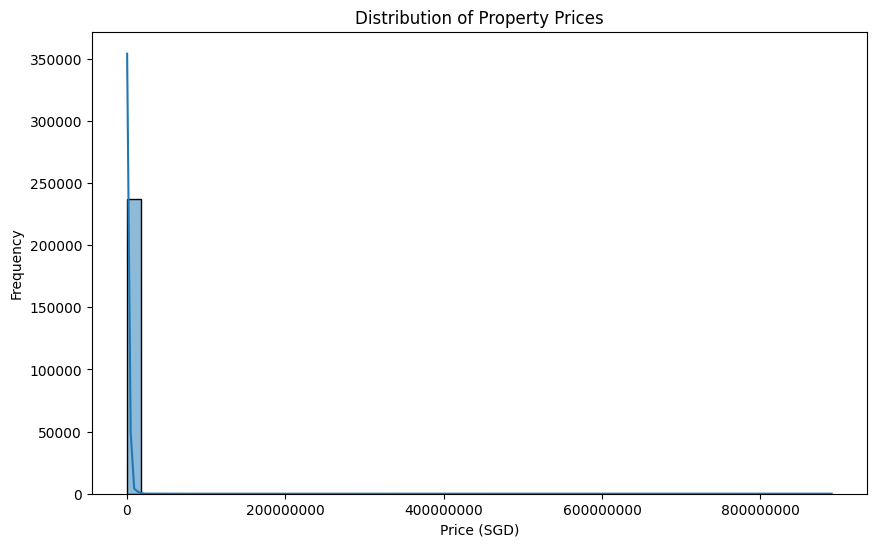

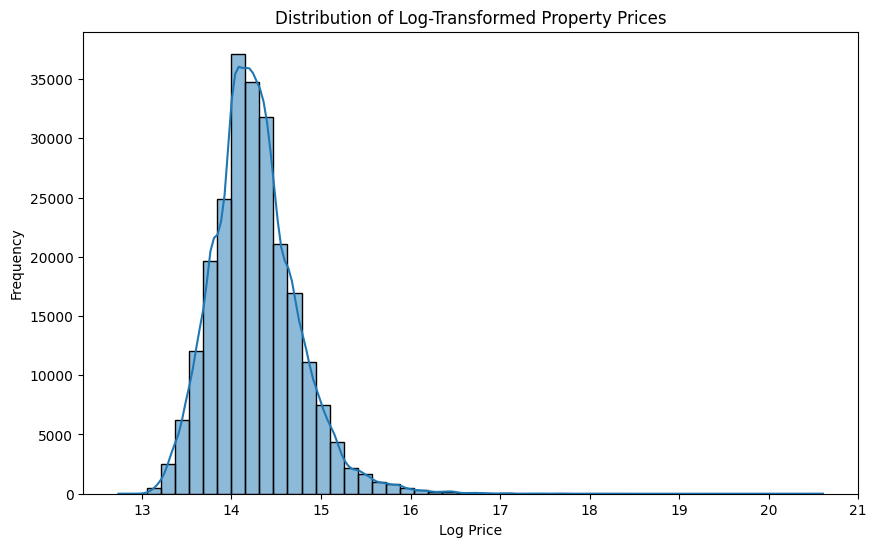

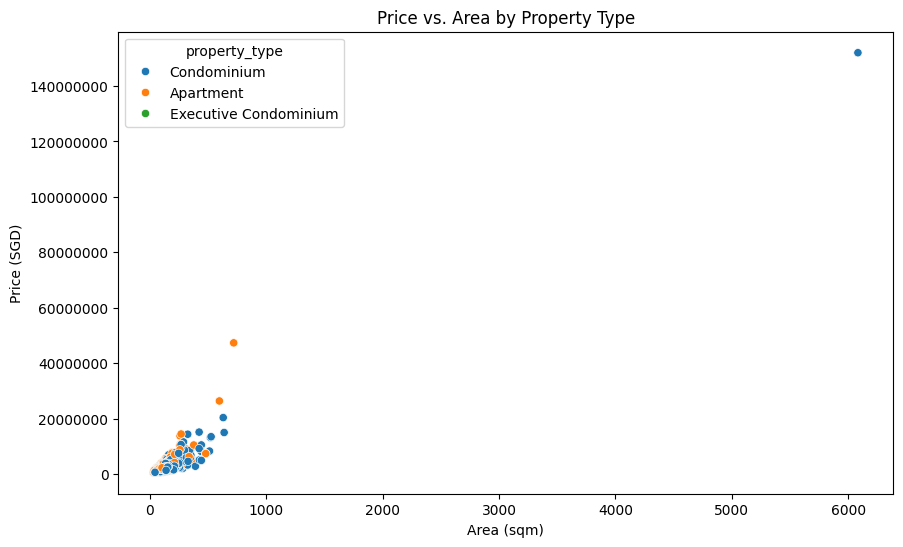


Selecting features for modeling...
Number of selected features: 30
Selected features:
['district', 'region', 'is_premium_location', 'x_coord', 'y_coord', 'latitude', 'longitude', 'property_type', 'is_ec', 'is_apartment', 'is_detached', 'is_semi_detached', 'is_terrace', 'is_strata', 'avg_floor', 'is_high_floor', 'area_sqm', 'size_category', 'log_area', 'tenure_type', 'is_freehold', 'is_new_sale', 'is_resale', 'is_subsale', 'transaction_year', 'transaction_quarter', 'years_since_transaction', 'project_name_hash', 'street_hash', 'area_region']

Preparing for model training...
Training data shape: (189974, 30)
Testing data shape: (47494, 30)

Data preparation complete! Ready for model training.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import pickle
import warnings
warnings.filterwarnings('ignore')

condo_data_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/condo_data_engineered.csv'
landed_data_path = '/content/drive/MyDrive/singapore-property-prediction/data/ura/processed/landed_data_engineered.csv'

print("Loading datasets...")
condo_data = pd.read_csv(condo_data_path)
landed_data = pd.read_csv(landed_data_path)

print(f"Condo data shape: {condo_data.shape}")
print(f"Landed data shape: {landed_data.shape}")

print("\nCondo data columns:")
print(condo_data.columns.tolist())
print("\nLanded data columns:")
print(landed_data.columns.tolist())

print("\nCreating log-transformed columns...")

if 'log_price' not in condo_data.columns:
    condo_data['log_price'] = np.log(condo_data['price'])
if 'log_price' not in landed_data.columns:
    landed_data['log_price'] = np.log(landed_data['price'])

if 'log_psm' not in condo_data.columns:
    condo_data['log_psm'] = np.log(condo_data['price_psm'])
if 'log_psm' not in landed_data.columns:
    landed_data['log_psm'] = np.log(landed_data['price_psm'])

if 'log_area' not in condo_data.columns:
    condo_data['log_area'] = np.log(condo_data['area_sqm'])
if 'log_area' not in landed_data.columns:
    landed_data['log_area'] = np.log(landed_data['area_sqm'])

print("\nHandling missing coordinates...")

condo_data['x_coord'].fillna(condo_data['x_coord'].mean(), inplace=True)
condo_data['y_coord'].fillna(condo_data['y_coord'].mean(), inplace=True)
landed_data['x_coord'].fillna(landed_data['x_coord'].mean(), inplace=True)
landed_data['y_coord'].fillna(landed_data['y_coord'].mean(), inplace=True)

print("\nChecking for duplicates...")
print(f"Condo data duplicates: {condo_data.duplicated().sum()}")
print(f"Landed data duplicates: {landed_data.duplicated().sum()}")

condo_data = condo_data.drop_duplicates()
landed_data = landed_data.drop_duplicates()

print(f"Condo data shape after removing duplicates: {condo_data.shape}")
print(f"Landed data shape after removing duplicates: {landed_data.shape}")

print("\nExtracting floor information...")
def extract_floor_info(floor_range):
    try:
        if pd.isna(floor_range) or floor_range == '':
            return None, None, None, False

        if isinstance(floor_range, str) and floor_range.lower() in ['ground floor', 'ground', 'g']:
            return 1, 1, 1, False

        if not isinstance(floor_range, str):
            return None, None, None, False

        parts = floor_range.replace('#', '').replace('TO', '-').replace('to', '-').split('-')

        lower_digits = ''.join(filter(str.isdigit, parts[0])) if parts[0].strip() else None
        lower = int(lower_digits) if lower_digits else None

        upper_digits = ''.join(filter(str.isdigit, parts[1])) if len(parts) > 1 and parts[1].strip() else None
        upper = int(upper_digits) if upper_digits else lower

        if lower is not None and upper is not None:
            avg_floor = (lower + upper) / 2
        else:
            avg_floor = lower if lower is not None else None

        is_high_floor = avg_floor > 10 if avg_floor is not None else False

        return avg_floor, lower, upper, is_high_floor
    except Exception as e:
        print(f"Error processing floor range: {floor_range}, Error: {e}")
        return None, None, None, False

try:
    condo_data[['avg_floor', 'lower_floor', 'upper_floor', 'is_high_floor']] = pd.DataFrame(
        condo_data['floor_range'].apply(lambda x: extract_floor_info(x)).tolist(),
        index=condo_data.index
    )

    landed_data[['avg_floor', 'lower_floor', 'upper_floor', 'is_high_floor']] = pd.DataFrame(
        landed_data['floor_range'].apply(lambda x: extract_floor_info(x)).tolist(),
        index=landed_data.index
    )
except Exception as e:
    print(f"Error extracting floor information: {e}")
    for df in [condo_data, landed_data]:
        df['avg_floor'] = None
        df['lower_floor'] = None
        df['upper_floor'] = None
        df['is_high_floor'] = False

print("\nCreating additional features...")

condo_data['project_street'] = condo_data['project_name'] + ' ' + condo_data['street']
landed_data['project_street'] = landed_data['project_name'] + ' ' + landed_data['street']

current_year = 2025
condo_data['years_since_transaction'] = current_year - condo_data['transaction_year']
landed_data['years_since_transaction'] = current_year - landed_data['transaction_year']

condo_data['area_region'] = condo_data['area_sqm'] * condo_data['region'].astype('category').cat.codes
landed_data['area_region'] = landed_data['area_sqm'] * landed_data['region'].astype('category').cat.codes

print("\nHandling high cardinality features...")

condo_data['project_name_hash'] = condo_data['project_name'].apply(lambda x: hash(str(x)) % 100)
condo_data['street_hash'] = condo_data['street'].apply(lambda x: hash(str(x)) % 100)
landed_data['project_name_hash'] = landed_data['project_name'].apply(lambda x: hash(str(x)) % 100)
landed_data['street_hash'] = landed_data['street'].apply(lambda x: hash(str(x)) % 100)

print("\nCombining datasets...")

condo_cols = set(condo_data.columns)
landed_cols = set(landed_data.columns)
common_cols = condo_cols.intersection(landed_cols)
condo_only = condo_cols - landed_cols
landed_only = landed_cols - condo_cols

print(f"Common columns: {len(common_cols)}")
print(f"Columns only in condo data: {condo_only}")
print(f"Columns only in landed data: {landed_only}")

for col in landed_only:
    if col in ['is_detached', 'is_semi_detached', 'is_terrace', 'is_strata']:
        condo_data[col] = False
    else:
        condo_data[col] = np.nan

for col in condo_only:
    if col in ['is_ec', 'is_apartment']:
        landed_data[col] = False
    else:
        landed_data[col] = np.nan

df = pd.concat([condo_data, landed_data], ignore_index=True)
print(f"Combined data shape: {df.shape}")

print("\nExploring combined data...")

print("\nProperty type distribution:")
print(df['property_type'].value_counts())

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribution of Property Prices')
plt.xlabel('Price (SGD)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['log_price'], kde=True, bins=50)
plt.title('Distribution of Log-Transformed Property Prices')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='area_sqm', y='price', hue='property_type', data=df.sample(min(5000, len(df))))
plt.title('Price vs. Area by Property Type')
plt.xlabel('Area (sqm)')
plt.ylabel('Price (SGD)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

print("\nSelecting features for modeling...")
features = [
    'district', 'region', 'is_premium_location',
    'x_coord', 'y_coord', 'latitude', 'longitude',
    'property_type',
    'is_ec', 'is_apartment', 'is_detached', 'is_semi_detached', 'is_terrace', 'is_strata',
    'avg_floor', 'is_high_floor',
    'area_sqm', 'size_category', 'log_area',
    'tenure_type', 'is_freehold',
    'is_new_sale', 'is_resale', 'is_subsale',
    'transaction_year', 'transaction_quarter', 'years_since_transaction',
    'project_name_hash', 'street_hash',
    'area_region'
]

valid_features = [f for f in features if f in df.columns]
print(f"Number of selected features: {len(valid_features)}")
print("Selected features:")
print(valid_features)

print("\nPreparing for model training...")

target = 'log_price'

X = df[valid_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

print("\nData preparation complete! Ready for model training.")

#Train Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
import pickle
import gc
import time
import warnings
warnings.filterwarnings('ignore')

def check_memory_usage():
    """Print current memory usage"""
    import psutil
    process = psutil.Process()
    memory_info = process.memory_info()
    memory_gb = memory_info.rss / (1024 * 1024 * 1024)
    print(f"Current memory usage: {memory_gb:.2f} GB")

print("Initial memory usage:")
check_memory_usage()

print("\nDefining preprocessing steps...")
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"Numeric features ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name=None):
    """Evaluate model performance with various metrics"""
    start_time = time.time()

    model.fit(X_train, y_train)

    train_time = time.time() - start_time

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    y_pred_orig = np.exp(y_pred_test)
    y_test_orig = np.exp(y_test)

    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

    del y_pred_train, y_pred_test, y_pred_orig, y_test_orig
    gc.collect()

    if model_name:
        print(f"\n{model_name} Results:")
        print(f"RMSE (Train): {rmse_train:.4f}")
        print(f"RMSE (Test): {rmse_test:.4f}")
        print(f"R² (Train): {r2_train:.4f}")
        print(f"R² (Test): {r2_test:.4f}")
        print(f"MAE (Test): {mae_test:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Training Time: {train_time:.2f} seconds")

    return {
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'MAE Test': mae_test,
        'MAPE': mape,
        'Training Time': train_time
    }

print("\nMemory usage after setup:")
check_memory_usage()

print("\nTraining XGBoost model...")
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=8,
        tree_method='gpu_hist',
        random_state=42
    ))
])

xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

with open('xgb_results.pkl', 'wb') as f:
    pickle.dump(xgb_results, f)

print("XGBoost model saved. Memory usage:")
check_memory_usage()

del xgb_model
gc.collect()
check_memory_usage()

Initial memory usage:
Current memory usage: 1.02 GB

Defining preprocessing steps...
Numeric features (14): ['district', 'x_coord', 'y_coord', 'latitude', 'longitude']...
Categorical features (16): ['region', 'is_premium_location', 'property_type', 'is_ec', 'is_apartment', 'is_detached', 'is_semi_detached', 'is_terrace', 'is_strata', 'is_high_floor', 'size_category', 'tenure_type', 'is_freehold', 'is_new_sale', 'is_resale', 'is_subsale']

Memory usage after setup:
Current memory usage: 1.00 GB

Training XGBoost model...

XGBoost Results:
RMSE (Train): 0.0812
RMSE (Test): 0.0918
R² (Train): 0.9707
R² (Test): 0.9626
MAE (Test): 0.0591
MAPE: 5.95%
Training Time: 2.19 seconds
XGBoost model saved. Memory usage:
Current memory usage: 0.99 GB
Current memory usage: 0.99 GB


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import lightgbm as lgb
import pickle
import gc
import time

try:
    with open('preprocessor.pkl', 'rb') as f:
        preprocessor = pickle.load(f)
    print("Loaded preprocessor from file")
except:
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    with open('preprocessor.pkl', 'wb') as f:
        pickle.dump(preprocessor, f)
    print("Created and saved preprocessor")

def check_memory_usage():
    import psutil
    process = psutil.Process()
    memory_info = process.memory_info()
    memory_gb = memory_info.rss / (1024 * 1024 * 1024)
    print(f"Current memory usage: {memory_gb:.2f} GB")

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name=None):
    """Evaluate model performance with various metrics"""
    start_time = time.time()

    model.fit(X_train, y_train)

    train_time = time.time() - start_time

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    y_pred_orig = np.exp(y_pred_test)
    y_test_orig = np.exp(y_test)

    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

    del y_pred_train, y_pred_test, y_pred_orig, y_test_orig
    gc.collect()

    if model_name:
        print(f"\n{model_name} Results:")
        print(f"RMSE (Train): {rmse_train:.4f}")
        print(f"RMSE (Test): {rmse_test:.4f}")
        print(f"R² (Train): {r2_train:.4f}")
        print(f"R² (Test): {r2_test:.4f}")
        print(f"MAE (Test): {mae_test:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Training Time: {train_time:.2f} seconds")

    return {
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'MAE Test': mae_test,
        'MAPE': mape,
        'Training Time': train_time
    }

print("\nTraining LightGBM model...")
check_memory_usage()

lgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        device='gpu',  # Use GPU
        random_state=42
    ))
])

lgb_results = evaluate_model(lgb_model, X_train, X_test, y_train, y_test, "LightGBM")

with open('lightgbm_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

with open('lgb_results.pkl', 'wb') as f:
    pickle.dump(lgb_results, f)

print("LightGBM model saved. Memory usage:")
check_memory_usage()

del lgb_model
gc.collect()
check_memory_usage()

Created and saved preprocessor

Training LightGBM model...
Current memory usage: 1.01 GB
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 189974, number of used features: 41
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (3.62 MB) transferred to GPU in 0.003780 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 14.266968

LightGBM Results:
RMSE (Train): 0.1140
RMSE (Test): 0.1176
R² (Train): 0.9422
R² (Test): 0.9386
MAE (Test): 0.0833
MAPE: 8.44%
Training Time: 6.62 seconds
LightGBM model saved. Memory usage:
Current memory usage: 1.21 GB
Current memory usage: 1.21 GB


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import pickle
import gc
import time

def check_memory_usage():
    import psutil
    process = psutil.Process()
    memory_info = process.memory_info()
    memory_gb = memory_info.rss / (1024 * 1024 * 1024)
    print(f"Current memory usage: {memory_gb:.2f} GB")

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name=None):
    """Evaluate model performance with various metrics"""
    print(f"Checking for NaN values in training data...")
    print(f"X_train NaN count: {X_train.isna().sum().sum()}")
    print(f"X_test NaN count: {X_test.isna().sum().sum()}")
    print(f"y_train NaN count: {pd.isna(y_train).sum()}")
    print(f"y_test NaN count: {pd.isna(y_test).sum()}")

    start_time = time.time()

    model.fit(X_train, y_train)

    train_time = time.time() - start_time

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    y_pred_orig = np.exp(y_pred_test)
    y_test_orig = np.exp(y_test)

    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

    del y_pred_train, y_pred_test, y_pred_orig, y_test_orig
    gc.collect()

    if model_name:
        print(f"\n{model_name} Results:")
        print(f"RMSE (Train): {rmse_train:.4f}")
        print(f"RMSE (Test): {rmse_test:.4f}")
        print(f"R² (Train): {r2_train:.4f}")
        print(f"R² (Test): {r2_test:.4f}")
        print(f"MAE (Test): {mae_test:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Training Time: {train_time:.2f} seconds")

    return {
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'MAE Test': mae_test,
        'MAPE': mape,
        'Training Time': train_time
    }

print("Columns with NaN values in X_train:")
nan_columns = X_train.columns[X_train.isna().any()].tolist()
for col in nan_columns:
    nan_count = X_train[col].isna().sum()
    nan_percent = (nan_count / len(X_train)) * 100
    print(f"- {col}: {nan_count} NaNs ({nan_percent:.2f}%)")

X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

for col in X_train.select_dtypes(include=['int64', 'float64']).columns:
    if X_train[col].isna().any():
        mean_value = X_train[col].mean()
        X_train_imputed[col].fillna(mean_value, inplace=True)
        X_test_imputed[col].fillna(mean_value, inplace=True)
        print(f"Imputed {col} with mean: {mean_value}")

for col in X_train.select_dtypes(include=['object', 'bool']).columns:
    if X_train[col].isna().any():
        most_frequent = X_train[col].mode()[0]
        X_train_imputed[col].fillna(most_frequent, inplace=True)
        X_test_imputed[col].fillna(most_frequent, inplace=True)
        print(f"Imputed {col} with most frequent value: {most_frequent}")

print(f"\nAfter imputation - X_train NaN count: {X_train_imputed.isna().sum().sum()}")
print(f"After imputation - X_test NaN count: {X_test_imputed.isna().sum().sum()}")

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ],
    remainder='passthrough'
)

print("\nTraining ElasticNet model with proper imputation...")
check_memory_usage()

elasticnet_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
])

elasticnet_results = evaluate_model(elasticnet_model, X_train_imputed, X_test_imputed, y_train, y_test, "ElasticNet")

with open('elasticnet_model.pkl', 'wb') as f:
    pickle.dump(elasticnet_model, f)

with open('elasticnet_results.pkl', 'wb') as f:
    pickle.dump(elasticnet_results, f)

print("ElasticNet model saved. Memory usage:")
check_memory_usage()

del elasticnet_model
gc.collect()
check_memory_usage()

Columns with NaN values in X_train:
- avg_floor: 233 NaNs (0.12%)
Imputed avg_floor with mean: 10.031875029645676

After imputation - X_train NaN count: 0
After imputation - X_test NaN count: 0

Training ElasticNet model with proper imputation...
Current memory usage: 1.29 GB
Checking for NaN values in training data...
X_train NaN count: 0
X_test NaN count: 0
y_train NaN count: 0
y_test NaN count: 0

ElasticNet Results:
RMSE (Train): 0.2784
RMSE (Test): 0.2776
R² (Train): 0.6550
R² (Test): 0.6578
MAE (Test): 0.2183
MAPE: 21.99%
Training Time: 1.82 seconds
ElasticNet model saved. Memory usage:
Current memory usage: 1.31 GB
Current memory usage: 1.31 GB


#Compare the models

In [ ]:
import pandas as pd
import numpy as np
import pickle
import gc

with open('xgb_results.pkl', 'rb') as f:
    xgb_results = pickle.load(f)

with open('lgb_results.pkl', 'rb') as f:
    lgb_results = pickle.load(f)

with open('elasticnet_results.pkl', 'rb') as f:
    elasticnet_results = pickle.load(f)

results = {
    'XGBoost': xgb_results,
    'LightGBM': lgb_results,
    'ElasticNet': elasticnet_results
}

print("\nModel Comparison:")
results_df = pd.DataFrame(results).T
print(results_df)

best_model_name = results_df['R² Test'].idxmax()
print(f"\nBest model: {best_model_name} with R² = {results_df.loc[best_model_name, 'R² Test']:.4f}")

if best_model_name == 'XGBoost':
    with open('xgboost_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
elif best_model_name == 'LightGBM':
    with open('lightgbm_model.pkl', 'rb') as f:
        best_model = pickle.load(f)
else:
    with open('elasticnet_model.pkl', 'rb') as f:
        best_model = pickle.load(f)

with open('property_valuation_final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"Final model saved as property_valuation_final_model.pkl")


Model Comparison:
            RMSE Train  RMSE Test  R² Train   R² Test  MAE Test       MAPE  \
XGBoost       0.081176   0.091793  0.970673  0.962592  0.059099   5.948116   
LightGBM      0.113996   0.117618  0.942166  0.938582  0.083253   8.436724   
ElasticNet    0.278438   0.277617  0.654966  0.657832  0.218252  21.987838   

            Training Time  
XGBoost          2.187729  
LightGBM         6.618389  
ElasticNet       1.824128  

Best model: XGBoost with R² = 0.9626
Final model saved as property_valuation_final_model.pkl


In [ ]:
import pandas as pd
import numpy as np
import pickle

with open('property_valuation_final_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

def predict_property_valuation(
    district, property_type, area_sqm, floor=None,
    premium_location=False, freehold=False,
    region=None, is_new_sale=False, is_resale=True
):
    """
    Simplified function to predict property valuation
    """
    property_data = {feature: 0 for feature in valid_features}

    property_data.update({
        'district': district,
        'property_type': property_type,
        'area_sqm': area_sqm,
        'log_area': np.log(area_sqm),
        'is_premium_location': premium_location,
        'is_freehold': freehold,
        'is_new_sale': is_new_sale,
        'is_resale': is_resale,
        'is_subsale': not (is_new_sale or is_resale),
        'avg_floor': floor if floor is not None else 1,
        'is_high_floor': floor > 10 if floor is not None else False,
        'region': region if region else 'CCR',
        'tenure_type': 'FREEHOLD' if freehold else '99 YEARS',
        'transaction_year': 2025,
        'transaction_quarter': 1,
        'years_since_transaction': 0,
        'is_ec': 'EXECUTIVE CONDOMINIUM' in property_type,
        'is_apartment': 'APARTMENT' in property_type,
        'is_detached': 'DETACHED' in property_type,
        'is_semi_detached': 'SEMI-DETACHED' in property_type,
        'is_terrace': 'TERRACE' in property_type,
        'is_strata': True
    })

    if area_sqm < 50:
        property_data['size_category'] = 'SMALL'
    elif area_sqm < 100:
        property_data['size_category'] = 'MEDIUM'
    elif area_sqm < 200:
        property_data['size_category'] = 'LARGE'
    else:
        property_data['size_category'] = 'VERY LARGE'

    region_code = {'CCR': 0, 'RCR': 1, 'OCR': 2}.get(property_data['region'], 0)
    property_data['area_region'] = area_sqm * region_code

    property_data['x_coord'] = 28000
    property_data['y_coord'] = 35000
    property_data['latitude'] = 1.3
    property_data['longitude'] = 103.8
    property_data['project_name_hash'] = 50
    property_data['street_hash'] = 50

    log_prediction = best_model.predict(pd.DataFrame([property_data]))
    prediction = np.exp(log_prediction)
    return prediction[0]

examples = [
    {"district": 10, "property_type": "CONDOMINIUM", "area_sqm": 100, "floor": 15,
     "premium_location": True, "freehold": True, "region": "CCR"},

    {"district": 19, "property_type": "CONDOMINIUM", "area_sqm": 80, "floor": 8,
     "premium_location": False, "freehold": False, "region": "OCR"},

    {"district": 15, "property_type": "TERRACE HOUSE", "area_sqm": 250,
     "premium_location": True, "freehold": True, "region": "RCR"}
]

print("\nExample predictions:")
for i, example in enumerate(examples):
    try:
        value = predict_property_valuation(**example)
        print(f"Example {i+1}: {example['property_type']} in District {example['district']}, "
              f"{example['area_sqm']} sqm - Predicted Value: SGD {value:,.2f}")
    except Exception as e:
        print(f"Error with example {i+1}: {e}")

print("\nModel training and evaluation complete!")


Example predictions:
Example 1: CONDOMINIUM in District 10, 100 sqm - Predicted Value: SGD 2,832,878.50
Example 2: CONDOMINIUM in District 19, 80 sqm - Predicted Value: SGD 1,804,343.38
Example 3: TERRACE HOUSE in District 15, 250 sqm - Predicted Value: SGD 3,236,606.50

Model training and evaluation complete!


#Save the Model

In [ ]:
from google.colab import drive
import os
import pickle

drive.mount('/content/drive', force_remount=True)

save_path = '/content/drive/MyDrive/private-models'
os.makedirs(save_path, exist_ok=True)

print(f"Saving models to {save_path}")

with open(os.path.join(save_path, 'property_valuation_xgboost.pkl'), 'wb') as f:
    pickle.dump(best_model, f)
print("Saved XGBoost model")

def predict_property_valuation(
    district, property_type, area_sqm, floor=None,
    premium_location=False, freehold=False,
    region=None, is_new_sale=False, is_resale=True
):
    """
    Simplified function to predict property valuation based on key inputs
    """
    input_data = {
        'district': district,
        'property_type': property_type,
        'area_sqm': area_sqm,
        'log_area': np.log(area_sqm),
        'is_premium_location': premium_location,
        'is_freehold': freehold,
        'is_new_sale': is_new_sale,
        'is_resale': is_resale,
        'is_subsale': not (is_new_sale or is_resale),
        'avg_floor': floor if floor is not None else 1,
        'is_high_floor': floor > 10 if floor is not None else False,
        'region': region if region else 'CCR',
        'tenure_type': 'FREEHOLD' if freehold else '99 YEARS',
        'transaction_year': 2025,
        'transaction_quarter': 1,
        'years_since_transaction': 0,
        'is_ec': 'EXECUTIVE CONDOMINIUM' in property_type,
        'is_apartment': 'APARTMENT' in property_type,
        'is_detached': 'DETACHED' in property_type,
        'is_semi_detached': 'SEMI-DETACHED' in property_type,
        'is_terrace': 'TERRACE' in property_type,
        'is_strata': True,
        'x_coord': 28000,
        'y_coord': 35000,
        'latitude': 1.3,
        'longitude': 103.8,
        'project_name_hash': 50,
        'street_hash': 50
    }

    if area_sqm < 50:
        input_data['size_category'] = 'SMALL'
    elif area_sqm < 100:
        input_data['size_category'] = 'MEDIUM'
    elif area_sqm < 200:
        input_data['size_category'] = 'LARGE'
    else:
        input_data['size_category'] = 'VERY LARGE'

    region_code = {'CCR': 0, 'RCR': 1, 'OCR': 2}.get(input_data['region'], 0)
    input_data['area_region'] = area_sqm * region_code

    missing_features = set(valid_features) - set(input_data.keys())
    for feature in missing_features:
        input_data[feature] = 0  # Default to 0 for any missing features

    input_df = pd.DataFrame([input_data])[valid_features]

    log_prediction = best_model.predict(input_df)

    prediction = np.exp(log_prediction)
    return prediction[0]

with open(os.path.join(save_path, 'property_valuation_function.pkl'), 'wb') as f:
    pickle.dump(predict_property_valuation, f)
print("Saved prediction function")

with open(os.path.join(save_path, 'valid_features.pkl'), 'wb') as f:
    pickle.dump(valid_features, f)
print("Saved valid features list")

with open(os.path.join(save_path, 'use_property_model.py'), 'w') as f:
    f.write("""
import pickle
import pandas as pd
import numpy as np
import os

current_dir = os.path.dirname(os.path.abspath(__file__))

with open(os.path.join(current_dir, 'property_valuation_function.pkl'), 'rb') as f:
    predict_property_valuation = pickle.load(f)

def value_property(district, property_type, area_sqm, floor=None,
                   premium_location=False, freehold=False,
                   region=None, is_new_sale=False, is_resale=True):
    \"\"\"
    User-friendly function to predict Singapore property values
    \"\"\"
    return predict_property_valuation(
        district=district,
        property_type=property_type,
        area_sqm=area_sqm,
        floor=floor,
        premium_location=premium_location,
        freehold=freehold,
        region=region,
        is_new_sale=is_new_sale,
        is_resale=is_resale
    )

if __name__ == "__main__":

    value1 = value_property(
        district=10,
        property_type="CONDOMINIUM",
        area_sqm=100,
        floor=15,
        premium_location=True,
        freehold=True,
        region="CCR"
    )
    print(f"District 10 CCR Condominium (100 sqm): SGD {value1:,.2f}")


    value2 = value_property(
        district=19,
        property_type="CONDOMINIUM",
        area_sqm=80,
        floor=8,
        premium_location=False,
        freehold=False,
        region="OCR"
    )
    print(f"District 19 OCR Condominium (80 sqm): SGD {value2:,.2f}")

    value3 = value_property(
        district=15,
        property_type="TERRACE HOUSE",
        area_sqm=250,
        premium_location=True,
        freehold=True,
        region="RCR"
    )
    print(f"District 15 RCR Terrace House (250 sqm): SGD {value3:,.2f}")
""")
print("Saved Python usage script")


Mounted at /content/drive
Saving models to /content/drive/MyDrive/private-models
Saved XGBoost model
Saved prediction function
Saved valid features list
Saved Python usage script
